# Performing visualization of simulation data

This notebook is a tutorial on working with `Tidy3D` output data.

We will cover:

- Accessing data.

- Manipulating data.

- Visualizing data.

First we import the packages we'll need.

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web


## Setup

### Creating Simulation

First, let's make a [Simulation](../_autosummary/tidy3d.Simulation.html) so we have data to plot.

We will add each possible type of monitor into the simultion to explore their output data separately.

In [2]:
# simulation parameters
Lx, Ly, Lz = 5, 5, 5
min_steps_per_wvl = 32

# monitor parameters
freq0 = 2e14
freqs = np.linspace(1e14, 3e14, 11)
num_modes = 3

simulation = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
    run_time=4e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    structures=[
        td.Structure(
            geometry=td.Box(center=(0, 0, 0), size=(10001, 1.4, 1.5)),
            medium=td.Medium(permittivity=2),
            name="waveguide",
        ),
        td.Structure(
            geometry=td.Box(center=(0, 0.5, 0.5), size=(1.5, 1.4, 1.5)),
            medium=td.Medium(permittivity=2),
            name="scatterer",
        ),
    ],
    sources=[
        td.ModeSource(
            source_time=td.GaussianPulse(freq0=freq0, fwidth=6e13),
            center=(-2.0, 0.0, 0.0),
            size=(0.0, 3, 3),
            direction="+",
            mode_spec=td.ModeSpec(),
            mode_index=0,
        )
    ],
    monitors=[
        td.FieldMonitor(
            fields=["Ex", "Ey", "Ez"],
            size=(td.inf, 0, td.inf),
            center=(0, 0, 0),
            freqs=freqs,
            name="field",
        ),
        td.FieldTimeMonitor(
            fields=["Ex", "Ey", "Ez"],
            size=(td.inf, 0, td.inf),
            center=(0, 0, 0),
            interval=200,
            name="field_time",
        ),
        td.FluxMonitor(size=(0, 3, 3), center=(2, 0, 0), freqs=freqs, name="flux"),
        td.FluxTimeMonitor(
            size=(0, 3, 3), center=(2, 0, 0), interval=10, name="flux_time"
        ),
        td.ModeMonitor(
            size=(0, 3, 3),
            center=(2, 0, 0),
            freqs=freqs,
            mode_spec=td.ModeSpec(num_modes=num_modes),
            name="mode",
        ),
    ],
)


[15:20:57] WARNING: Default value for the field monitor           ]8;id=462994;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=791196;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=814897;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=467515;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

In [3]:
tmesh = simulation.tmesh

total_size_bytes = 0
for monitor in simulation.monitors:
    monitor_grid = simulation.discretize(monitor)
    num_cells = np.prod(monitor_grid.num_cells)
    monitor_size = monitor.storage_size(num_cells=num_cells, tmesh=tmesh)
    print(f"monitor {monitor.name} requires {monitor_size:.2e} bytes of storage.")


monitor field requires 7.06e+06 bytes of storage.
monitor field_time requires 1.06e+07 bytes of storage.
monitor flux requires 4.40e+01 bytes of storage.
monitor flux_time requires 2.65e+03 bytes of storage.
monitor mode requires 7.92e+02 bytes of storage.


### Visualize Geometry

We've created a simple waveguide with a defect / scattering region defined using a [Box](../_autosummary/tidy3d.Box.html) geometry.

A modal source is injected from the -x side of the simulation and we measure the mode amplitudes and flux at the +x side.

We've also placed a couple field monitors to visualize the field patterns.

Let's take a look at the geometry from a few cross sections.

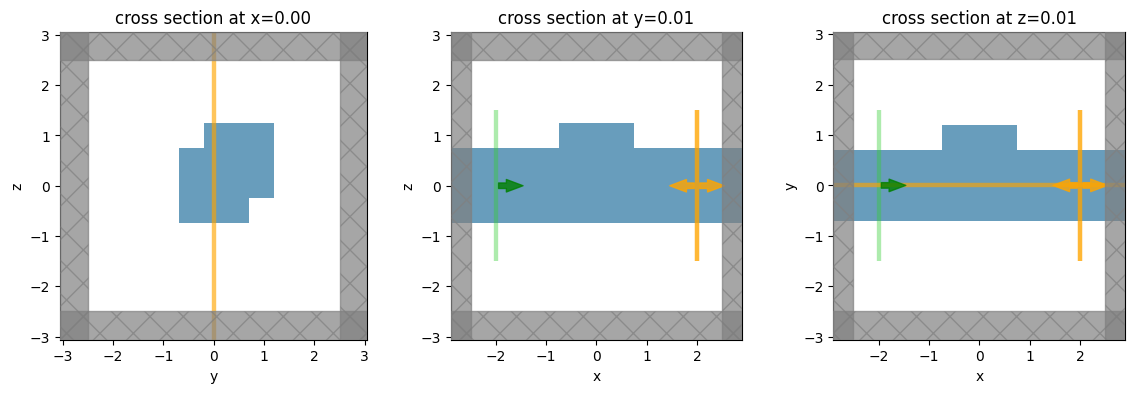

In [4]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
simulation.plot(x=0.0, ax=ax1)
simulation.plot(y=0.01, ax=ax2)
simulation.plot(z=0.01, ax=ax3)
plt.show()


### Make normalization Simulation

For purposes of demonstration, let's create another simulation without the scatterer, so we can compare what the data should look like for just the straight waveguide case.

This is as simple as making a copy of the original simulation and removing the scatterer from the list of structures.

In [5]:
# get rid of scatterer for normalization
simulation0 = simulation.copy(update=dict(structures=[simulation.structures[0]]))


### Running simulations

Now we will run both simulations and load them into [SimulationData](../_autosummary/tidy3d.SimulationData.html) objects.

Since these will be a short and simple simulations, we can use the [web.run](../_autosummary/tidy3d.web.run.html) function to do them all in one line.

In [6]:
sim0_data = web.run(
    simulation0,
    task_name="straight waveguide",
    path="data/simulation0.hdf5",
    verbose=True,
)

sim_data = web.run(
    simulation,
    task_name="scattered waveguide",
    path="data/simulation.hdf5",
    verbose=True,
)


[15:20:58] Created task 'straight waveguide' with task_id          ]8;id=555556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=610376;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1'.                       

           View task using web UI at                               ]8;id=386472;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=77283;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=384978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=415959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\taskId]8;;\]8;id=384978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\=]8;;\]8;id=695975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\fdve]8;;\]8;id=384978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\-]8;;\              
           ]8;id=384978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a81e80bb-710f-4f9c-80e0-95da36d80335v1\a81e80bb-710f-4f9c-80e0-95da36d80335v1']8;;\.                             

Output()

[15:20:59] status = queued                                         ]8;id=993056;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=47783;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[15:21:03] status = preprocess                                     ]8;id=722856;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=22749;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[15:21:08] Maximum FlexCredit cost: 0.025. Use                     ]8;id=601192;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=354366;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=522285;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=878329;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=872449;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=151386;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=423215;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=701788;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[15:21:14] early shutoff detected, exiting.                        ]8;id=923181;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=353136;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=440387;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=168563;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#420\420]8;;\

Output()

[15:21:35] status = success                                        ]8;id=712257;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=623170;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#427\427]8;;\

Output()

[15:21:36] loading SimulationData from data/simulation0.hdf5       ]8;id=450461;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=23865;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\

           Created task 'scattered waveguide' with task_id         ]8;id=545284;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=249974;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1'.                       

           View task using web UI at                               ]8;id=103032;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=462157;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=596155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=641547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\taskId]8;;\]8;id=596155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\=]8;;\]8;id=868152;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\fdve]8;;\]8;id=596155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\-]8;;\              
           ]8;id=596155;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d66a2a3e-747f-4c19-a006-a44490a50d38v1\d66a2a3e-747f-4c19-a006-a44490a50d38v1']8;;\.                             

Output()

[15:21:37] status = queued                                         ]8;id=978095;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449283;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[15:21:42] status = preprocess                                     ]8;id=731942;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=775962;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[15:21:46] Maximum FlexCredit cost: 0.025. Use                     ]8;id=620419;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=504000;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=28915;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=324337;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=762099;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=104529;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=668710;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=395422;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[15:21:53] early shutoff detected, exiting.                        ]8;id=627853;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=841540;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=974829;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=75167;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#420\420]8;;\

Output()

[15:22:13] status = success                                        ]8;id=685445;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=437822;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#427\427]8;;\

Output()

[15:22:14] loading SimulationData from data/simulation.hdf5        ]8;id=311336;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=735297;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\

### Inspecting Log

Now let's take a look at the log to see if everything looks ok (fields decayed, etc).

In [7]:
print(sim_data.log)


Simulation domain Nx, Ny, Nz: [176, 152, 152]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.2214e+06.
Using subpixel averaging: True
Number of time steps: 6.6230e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 6.0408e-17


Compute source modes time (s):     0.4482
Compute monitor modes time (s):    2.5589
Rest of setup time (s):            2.3952

Running solver for 6623 time steps...
- Time step    220 / time 1.33e-14s (  3 % done), field decay: 1.00e+00
- Time step    264 / time 1.59e-14s (  4 % done), field decay: 1.00e+00
- Time step    529 / time 3.20e-14s (  8 % done), field decay: 1.00e+00
- Time step    794 / time 4.80e-14s ( 12 % done), field decay: 8.03e-04
- Time step   1059 / time 6.40e-14s ( 16 % done), field decay: 1.36e-06
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):                   0.9497
Data write time (s):               0.0540



## Post-Processing

Now that the simulations have run and their data are loaded into the `sim_data` and `sim0_data` variables, we will explore how to access, manipulate, and visualize the data.  

### Accessing Data

#### Original Simulation

The [SimulationData](../_autosummary/tidy3d.SimulationData.html) objects store a copy of the original [Simulation](../_autosummary/tidy3d.Simulation.html), so it can be recovered if the [SimulationData](../_autosummary/tidy3d.SimulationData.html) is loaded in a new session and the [Simulation](../_autosummary/tidy3d.Simulation.html) is no longer in memory.

In [8]:
print(sim_data.simulation.size)


(5.0, 5.0, 5.0)


#### Monitor Data

More importantly, the [SimulationData](../_autosummary/tidy3d.SimulationData.html) contains a reference to the data for each of the monitors within the original [Simulation](../_autosummary/tidy3d.Simulation.html).
This data can be accessed directly using the `name` given to the monitors initially.

For example, our [FluxMonitor](../_autosummary/tidy3d.FluxMonitor.html) was named `'flux'` while our [FluxTimeMonitor](../_autosummary/tidy3d.FluxTimeMonitor.html) was named `'flux_time'`, each with a `.flux` attribute storing the raw data. Therefore, we can access the data as follows.

In [9]:
# get the flux data from the monitor name
flux_data = sim_data["flux"].flux
flux_time_data = sim_data["flux_time"].flux


### Structure of Data

Now that we have the data loaded, let's inspect it.

In [10]:
flux_data


<xarray.FluxDataArray (f: 11)>
array([0.5919975 , 0.7746099 , 0.8931861 , 0.9529229 , 0.97218525,
       0.9766577 , 0.97956336, 0.98391604, 0.9880343 , 0.99017584,
       0.9902634 ], dtype=float32)
Coordinates:
  * f        (f) float64 1e+14 1.2e+14 1.4e+14 1.6e+14 ... 2.6e+14 2.8e+14 3e+14
Attributes:
    units:      W
    long_name:  flux

The data is stored as a [DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) object using the [xarray](https://xarray.pydata.org/en/stable/) package.
You can think of it as a dataset where the flux data is stored as a large, multi-dimensional array (like a numpy array) and the coordinates along each of the dimensions are specified so it is easy to work with.

For example:

In [11]:
# flux values (W) as numpy array
print(f"shape of flux dataset = {flux_data.shape}\n.")
print(f"frequencies in dataset = {flux_data.coords.values} \n.")
print(f"flux values in dataset = {flux_data.values}\n.")


shape of flux dataset = (11,)
.
frequencies in dataset = <bound method Mapping.values of Coordinates:
  * f        (f) float64 1e+14 1.2e+14 1.4e+14 1.6e+14 ... 2.6e+14 2.8e+14 3e+14> 
.
flux values in dataset = [0.5919975  0.7746099  0.8931861  0.9529229  0.97218525 0.9766577
 0.97956336 0.98391604 0.9880343  0.99017584 0.9902634 ]
.


So we can see the datset stores a 1D array of flux values (Watts) and a 1D array of frequency values (Hz).

### Manipulating Data

We can now do some useful operations with this data, including:

In [12]:
# Selecting data at a specific coordinate
flux_central_freq = flux_data.sel(f=freq0)
print(f"at central frequency, flux is {float(flux_central_freq):.2e} W")


at central frequency, flux is 9.77e-01 W


In [13]:
# Selecting data at a specific index
flux_4th_freq = flux_data.isel(f=4)
print(f"at 4th frequency, flux is {float(flux_4th_freq):.2e} W")


at 4th frequency, flux is 9.72e-01 W


In [14]:
# Interpolating data at a specific coordinate
flux_interp_freq = flux_data.interp(f=213.243523142e12)
print(
    f"at an intermediate (not stored) frequency, flux is {float(flux_interp_freq):.2e} W"
)


at an intermediate (not stored) frequency, flux is 9.79e-01 W


In [15]:
# arithmetic opertions with numbers
flux_times_2_plus_1 = 2 * flux_data + 1


In [16]:
# operations with dataset (in this case, dividing by the normlization flux)
flux_transmission = flux_data / sim0_data["flux"].flux


There are mny more things you can do with the xarray package that are not covered here, so it is best to take a look at [their documention](http://xarray.pydata.org/en/stable/) for more details.

### Plotting Data

These datasets have built in plotting methods, which can be handy for quickly producing customizable plots.

Let's plot the flux data to get a feeling.

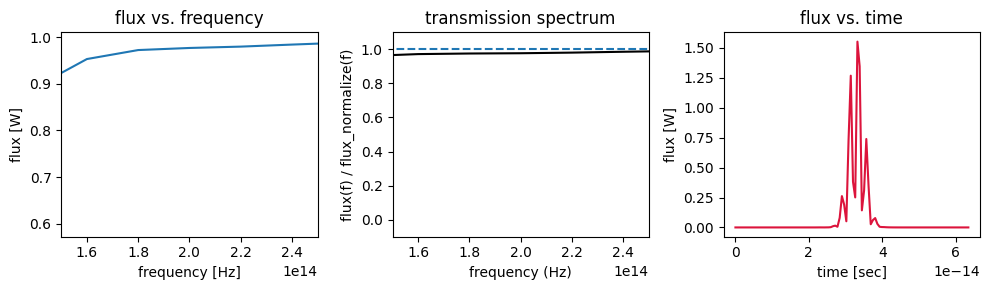

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
flux_data.plot(ax=ax1)
ax1.set_title("flux vs. frequency")
ax1.set_xlim(150e12, 250e12)

# plot the ratio of flux with scatterer to without scatterer with dashed line signifying unity transmission.
flux_transmission.plot(ax=ax2, color="k")
ax2.plot(flux_data.f, np.ones_like(flux_data.f), "--")
ax2.set_ylabel("flux(f) / flux_normalize(f)")
ax2.set_xlabel("frequency (Hz)")
ax2.set_title("transmission spectrum")
ax2.set_xlim(150e12, 250e12)
ax2.set_ylim(-0.1, 1.1)

# plot the time dependence of the flux
flux_time_data.plot(color="crimson", ax=ax3)
ax3.set_title("flux vs. time")

plt.show()


Conveniently, xarray adds a lot of the plot labels and formatting automatically, which can save some time.

### Complex, Multi-dimensional Data

While the flux data is 1D and quite simple, the same approaches apply to more complex data, such as mode amplitude and field data, which can be complex-valued and muli-dimensional.

Let's use the [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) data as an example.  We'll access the data using it's name `'mode'` in the original simulation and print out some of the metadata to examine.

In [18]:
mode_data = sim_data["mode"]
mode_data.amps.shape


(2, 11, 3)

As we can see, the data is complex-valued and contains three dimensions.
- a propagation direction for the mode, which is just positive or negative  (+/-)
- an index into the list of modes returned by the solver given our initial [ModeSpec](../_autosummary/tidy3d.ModeSpec.html) specifications.
- the frequency of the mode

Let's plot the data just to get a feeling for it, using `.sel()` to split the forward and backward propagating modes onto separate plot axes.

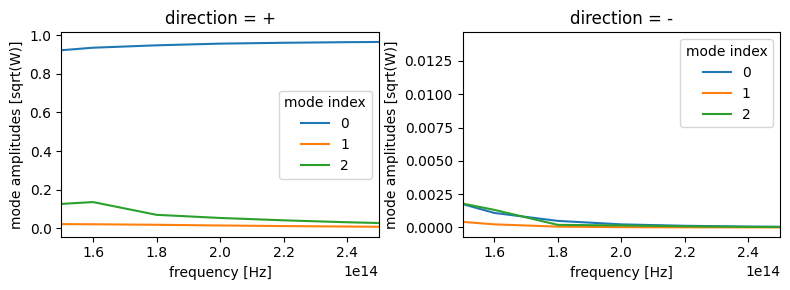

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))

mode_data.amps.sel(direction="+").abs.plot.line(x="f", ax=ax1)
mode_data.amps.sel(direction="-").abs.plot.line(x="f", ax=ax2)
ax1.set_xlim(150e12, 250e12)
ax2.set_xlim(150e12, 250e12)

plt.show()


As before, we can manipulate the data using basic algebra or xarray built ins, for example.

In [20]:
# sum abolute value squared of the mode amplitudes to get powers
mode_powers = abs(mode_data.amps) ** 2

# select the powers at the central frequency only
powers_central_freq = mode_powers.sel(f=freq0)

# sum the powers over all of the mode indices
powers_sum_modes = powers_central_freq.sum("mode_index")


## Field Data

Data from a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) or [FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html) is more complicated as it contains data from several field components.

As such, when we just grab the data by name, we dont get an xarray object, but rather a [FieldData](../_autosummary/tidy3d.FieldData.html) container holding all of the field components.


In [21]:
field_data = sim_data["field"]
field0_data = sim0_data["field"]
print(type(field_data))


<class 'tidy3d.components.data.monitor_data.FieldData'>


The field_data object contains data for each of the field components in it's `data_dict` dictionary.

Let's look at what field components are contined

In [22]:
print(field_data.dict().keys())


dict_keys(['type', 'Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz', 'monitor', 'symmetry', 'symmetry_center', 'grid_expanded', 'grid_primal_correction', 'grid_dual_correction'])


The individual field components, themselves, can be accessed conveniently using a "dot" syntax, and are stored similarly to the flux and mode data as xarray data arrays.

In [23]:
field_data.Ex


<xarray.ScalarFieldDataArray (x: 177, y: 1, z: 153, f: 11)>
array([[[[ 0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00-0.00000000e+00j, ...,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
          -0.00000000e+00-0.00000000e+00j],
         [ 7.95210795e-08+1.99940366e-08j,
          -6.85567443e-08+3.88300130e-08j,
          -2.84152595e-08-4.74311213e-09j, ...,
           2.72489462e-08+2.54324739e-08j,
          -3.22235856e-08+3.82810974e-08j,
          -1.22125527e-08-2.11765290e-08j],
         [ 1.62651236e-06-2.76807924e-07j,
          -8.04471824e-07+9.82091592e-07j,
          -5.46639683e-07-7.55580913e-08j, ...,
           7.84362783e-07+2.76406439e-07j,
          -3.74199118e-07+8.48379955e-07j,
          -5.43512840e-07-4.04517010e-07j],
         ...,
         [-8.28895992e-08-2.06892175e-08j,
...
           2.32582575e-08+8.71701218e-08j],
         ...,
         [ 5.03346342e-09-7.68457564e-09j,
           3.93810717e-09+6.88584922e-09j,
           4.68950767e-10-6.48289289e-09j, ...,
           1.75305448e-09+1.43542922e-09j,
          -8.94999908e-10-1.95260519e-09j,
           5.27523669e-09+2.15770110e-10j],
         [ 2.72701506e-09+2.05858344e-10j,
           1.40463019e-09-4.19253993e-10j,
           1.21352275e-10-6.58987254e-10j, ...,
           8.04554479e-11+1.45665938e-10j,
          -1.36488668e-10+1.14363553e-10j,
           5.73333381e-10+3.60232705e-10j],
         [ 0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00-0.00000000e+00j, ...,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
          -0.00000000e+00-0.00000000e+00j]]]], dtype=complex64)
Coordinates:
  * x        (x) float64 -2.896 -2.863 -2.83 -2.797 ... 2.797 2.83 2.863 2.896
  * y        (y) float64 0.0
  * z        (z) float64 -3.061 -3.015 -2.968 -2.921 ... 2.922 2.968 3.015 3.062
  * f        (f) float64 1e+14 1.2e+14 1.4e+14 1.6e+14 ... 2.6e+14 2.8e+14 3e+14
Attributes:
    long_name:  field value

In this case, the dimensions of the data are the spatial locations on the yee lattice (x,y,z) and the frequency.

### Colocating Field Data

For many advanced plots and other manipulations, it is convenient to have the field data co-located at the same positions, since they are naturally defined on separate locations on the yee lattice. There are several convenience methods that can be used for this.

In [24]:
# Colocate data to the Yee grid centers
field0_data_centered = sim0_data.at_centers("field").interp(f=200e12)
field_data_centered = sim_data.at_centers("field").interp(f=200e12)

# Colocate data to Yee grid boundaries
# Note: by default, data is already colocated there, unless `colocate=False` is set in the monitor.
# Here, at_boundaries just converts the Tidy3D data into an xarray Dataset.
field_data_boundaries = sim_data.at_boundaries("field").interp(f=200e12)

# Colocate to custom coordinates
# Note: some or all of the x/y/z coordinates can be provided
field_data_colocate_z = sim_data["field"].colocate(z=np.linspace(-1, 1, 21))


[15:22:17] WARNING: Colocating data that has already been          ]8;id=762637;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=795150;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

           WARNING: Colocating data that has already been          ]8;id=350051;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=725942;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

           WARNING: Colocating data that has already been          ]8;id=355293;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=29044;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

In [25]:
field0_data_centered = sim0_data.at_centers("field").interp(f=200e12)
field_data_centered = sim_data.at_centers("field").interp(f=200e12)


           WARNING: Colocating data that has already been          ]8;id=766292;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=666131;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

           WARNING: Colocating data that has already been          ]8;id=716100;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=696287;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

All these methods return an xarray [Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html), which provies similar functionality as the [DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) objects, but is aware of all of the field data and provides more convenience methods, as we will explore in the next section.

### Plotting Fields

#### Simple 
Plotting fields requires a little bit of manipulation to get them in the right shape, but then it is straightforward.

In [26]:
# get the field data on the y=0 plane at frequency 200THz
Ez_data = field_data.Ez.isel(y=0).interp(f=2e14)
Ez0_data = field0_data.Ez.isel(y=0).interp(f=2e14)


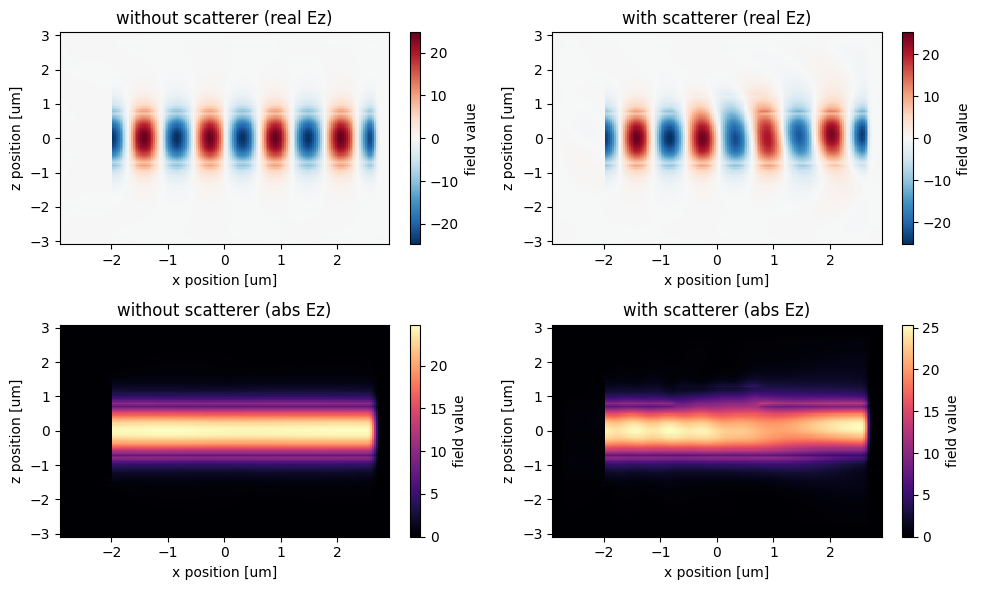

In [27]:
# amplitude plot rz Ex(x,y) field on plane
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(10, 6))

Ez0_data.real.plot(x="x", y="z", ax=ax1)
Ez_data.real.plot(x="x", y="z", ax=ax2)

abs(Ez0_data).plot(x="x", y="z", cmap="magma", ax=ax3)
abs(Ez_data).plot(x="x", y="z", cmap="magma", ax=ax4)

ax1.set_title("without scatterer (real Ez)")
ax2.set_title("with scatterer (real Ez)")
ax3.set_title("without scatterer (abs Ez)")
ax4.set_title("with scatterer (abs Ez)")
plt.show()


#### Advanced

More advanced plotting is available and is best done with the centered field data.

##### Structure Overlay

One can overlay the structure permittivity by calling `plot_fields` from the [SimulationData](../_autosummary/tidy3d.SimulationData.html) object as follows:

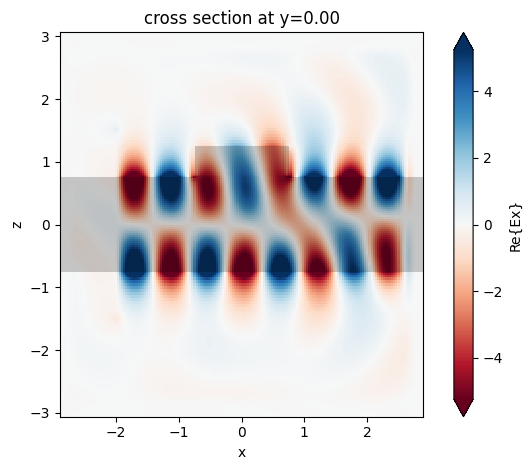

In [28]:
ax = sim_data.plot_field("field", "Ex", y=0.0, f=200e12, eps_alpha=0.2)


##### Quiver Plots

Quiver plotting can be done through the centered field Dataset.
We first should spatially downsample the data to be quivered to reduce clutter on the plot, which can be done by `.sel()` with `slice(None, None, skip)` range to select every `skip` data point along that axis.

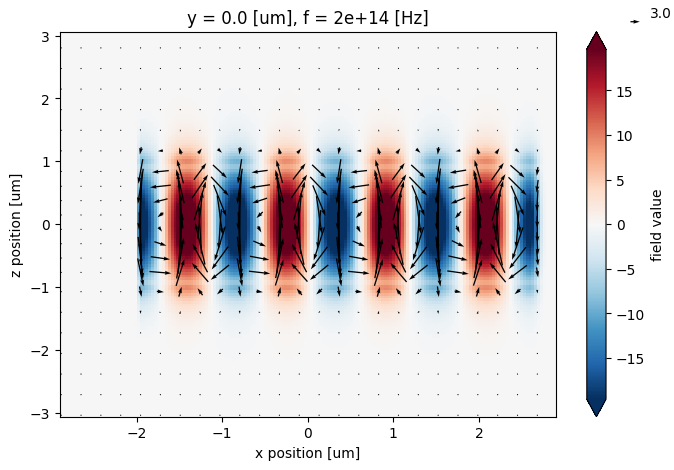

In [29]:
# downsample the field data for more clear quiver plotting
field0_data_resampled = field0_data_centered.sel(
    x=slice(None, None, 7), z=slice(None, None, 7)
)

# quiver plot of \vec{E}_{x,y}(x,y) on plane with Ez(x,y) underlying.
f, ax = plt.subplots(figsize=(8, 5))
field0_data_centered.isel(y=0).Ez.real.plot.imshow(x="x", y="z", ax=ax, robust=True)
field0_data_resampled.isel(y=0).real.plot.quiver("x", "z", "Ex", "Ez", ax=ax)
plt.show()


##### Stream Plots
Stream plots can be another useful feature, although they do not take the amplitude into account, so use with caution.

##### Time Lapse Fields

For time-domain data, it can be convenient to see the fields at various snapshots of the simulation.  For this, it is convenient to supply the `row` and `col` keyword arguments to plot, which expand all plots on a row or column.

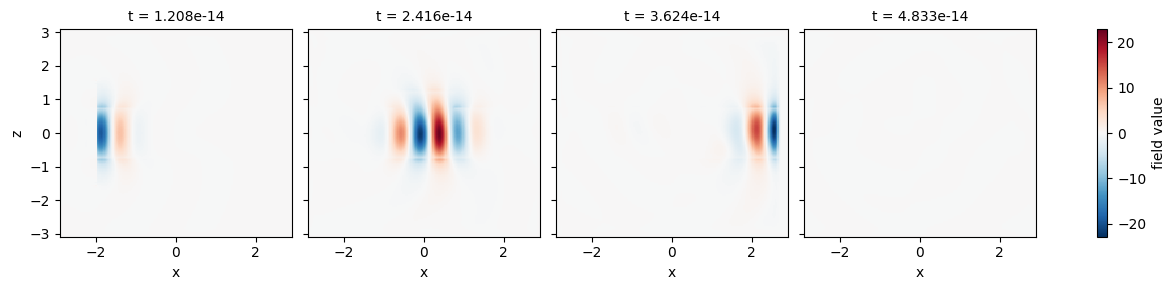

In [30]:
field_time_data = sim_data["field_time"]

# select the data and downsample and window the time coordinate to reduce number of plots.
time_data = field_time_data.Ez.isel(y=0).sel(t=slice(1e-14, 5e-14, 1))

time_data.plot(x="x", y="z", col="t")
plt.show()


## Export data to csv

In many cases, you might want to save the monitor data as a .csv file for future use. This can be done in multiple ways. Here we demonstrate two methods as examples. 

For saving a 2D array such as a field plot at a specific frequency or time instance, we can first convert the [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) to a [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) using the [to_numpy()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.to_numpy.html) method and then using numpy's [savetxt()](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html) method to save the 2D numpy array as a .csv file. The spatial coordinates can be saved as separate .csv files in the same way. 

In [31]:
# save Ez to a numpy array
Ez = Ez0_data.real.squeeze().to_numpy()

# save x coordinate to a numpy array
x_array = Ez0_data.real.coords['x'].to_numpy()

# save z coordinate to a numpy array
z_array =  Ez0_data.real.coords['z'].to_numpy()

# save the numpy arries to .csv files
np.savetxt('./data/Ez.csv', Ez, delimiter=',')
np.savetxt('./data/x.csv', x_array)
np.savetxt('./data/z.csv', z_array)

If the data you want to save is higher dimensional such as the field distribution at multiple time instances, you can consider export the [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) to a csv file using its [to_dataframe()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html) method.

In [32]:
df = time_data.to_dataframe("value")
df.to_csv("./data/time_data.csv")


It will stack the array coordinates to generate a 2D table. Import the csv file to check the content:

In [33]:
import pandas as pd

df = pd.read_csv("./data/time_data.csv")
display(df)


,x,z,t,y,value
0,-2.896226,-3.061435,1.208153e-14,0.0,0.0
1,-2.896226,-3.061435,2.416306e-14,0.0,0.0
2,-2.896226,-3.061435,3.624459e-14,0.0,0.0
3,-2.896226,-3.061435,4.832612e-14,0.0,0.0
4,-2.896226,-3.014649,1.208153e-14,0.0,0.0
...,...,...,...,...,...
108319,2.896226,3.015268,4.832612e-14,0.0,0.0
108320,2.896226,3.062111,1.208153e-14,0.0,0.0
108321,2.896226,3.062111,2.416306e-14,0.0,0.0
108322,2.896226,3.062111,3.624459e-14,0.0,0.0


## Load data 

When running the simulations, we have specified the path to save the simulation data, i.e. `path="data/simulation0.hdf5"`. It means the simulation data is saved as a .hdf5 file, which can be loaded into a [SimulationData](../_autosummary/tidy3d.SimulationData.html) object in the future for analysis. Here we demonstrate loading the .hdf5 files using the `from_file` method. If you performed a mode solving simulation instead of a FDTD simulation, [ModeSolverData](../_autosummary/tidy3d.ModeSolverData.html) can be loaded in a similar fashion. 

In [34]:
sim_data0 = td.SimulationData.from_file("data/simulation0.hdf5")
sim_data = td.SimulationData.from_file("data/simulation.hdf5")

After the simulation data is loaded, you can perform postprocessing as discussed above such as plotting the field distribution by using the `plot_field` method.

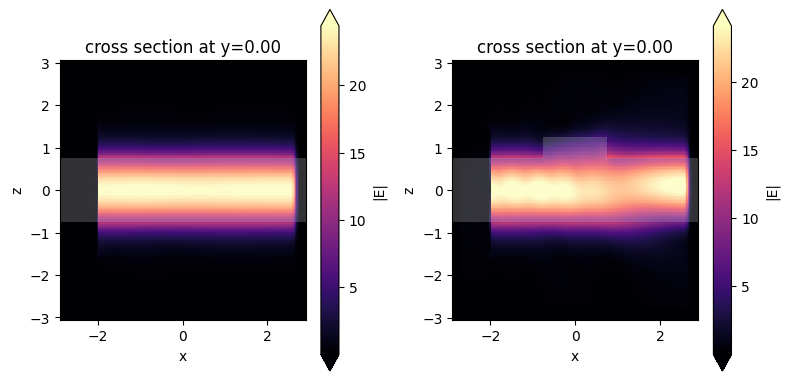

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(8, 4))
sim_data0.plot_field(field_monitor_name="field", field_name='E', val='abs', f=2e14, ax=ax1)
sim_data.plot_field(field_monitor_name="field", field_name='E', val='abs', f=2e14, ax=ax2)
plt.show()

## Conclusion

This hopefully gives some sense of what kind of data post processing and visualization can be done in `Tidy3D`.

For more detailed information and reference, the best places to check out are

* API reference for [SimulationData](../_autosummary/tidy3d.SimulationData.html).

* [Xarray documentation](http://xarray.pydata.org).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 